In [31]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import skimage.feature
import cv2



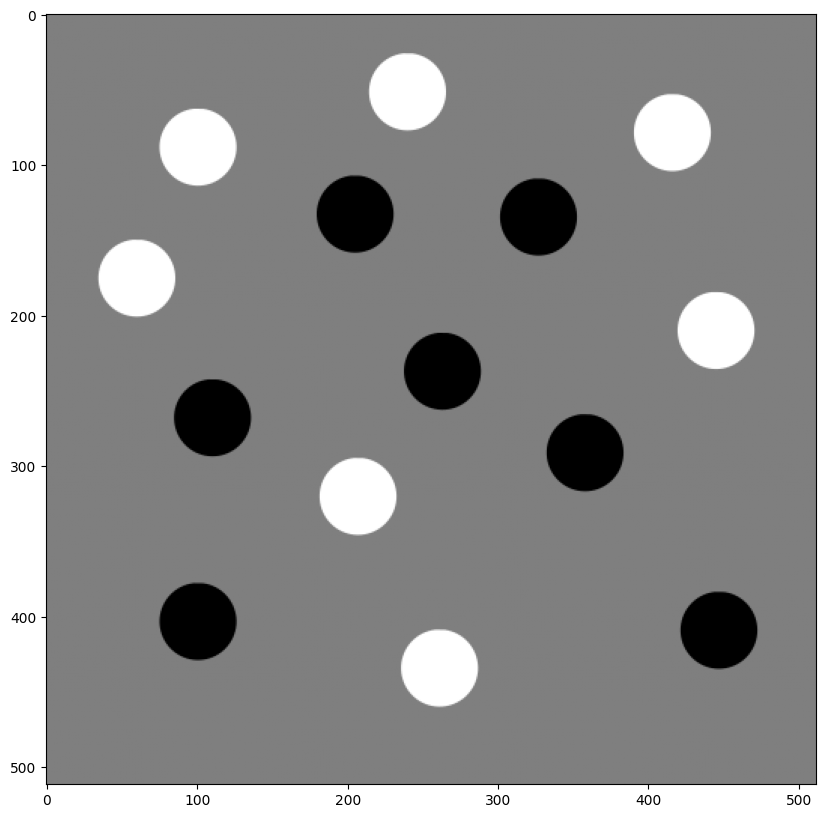

In [32]:
data_path = 'data/' 

im = skimage.io.imread(data_path + 'test_blob_uniform.png').astype(float)

fig, ax = plt.subplots(1,1,figsize=(10,10),sharex=True,sharey=True)
ax.imshow(im,cmap='gray')
plt.show();

In [33]:
def getGaussDerivative(t):
    '''
    Computes kernels of Gaussian and its derivatives.
    Parameters
    ----------
    t : float
        Variance - t.

    Returns
    -------
    g : numpy array
        Gaussian.
    dg : numpy array
        First order derivative of Gaussian.
    ddg : numpy array
        Second order derivative of Gaussian
    dddg : numpy array
        Third order derivative of Gaussian.

    '''

    kSize = 5  # Multiplier to determine kernel size (number of std deviations to include)
    s = np.sqrt(t)  # Standard deviation from variance
    # Create a 1D grid centered at 0, covering ±kSize*s
    x = np.arange(int(-np.ceil(s*kSize)), int(np.ceil(s*kSize))+1)
    x = np.reshape(x, (-1, 1))  # Make x a column vector for broadcasting

    # Compute the 1D Gaussian kernel
    g = np.exp(-x**2/(2*t))
    g = g / np.sum(g)  # Normalize so sum is 1

    # First derivative of Gaussian (with respect to x)
    dg = -x / t * g

    # Second derivative of Gaussian
    # d/dx of dg: -g/t + (-x/t)*dg
    ddg = -g / t - x / t * dg

    # Third derivative of Gaussian
    # d/dx of ddg: -dg/t + (-x/t)*ddg
    dddg = -2 * dg / t - x / t * ddg

    return g, dg, ddg, dddg


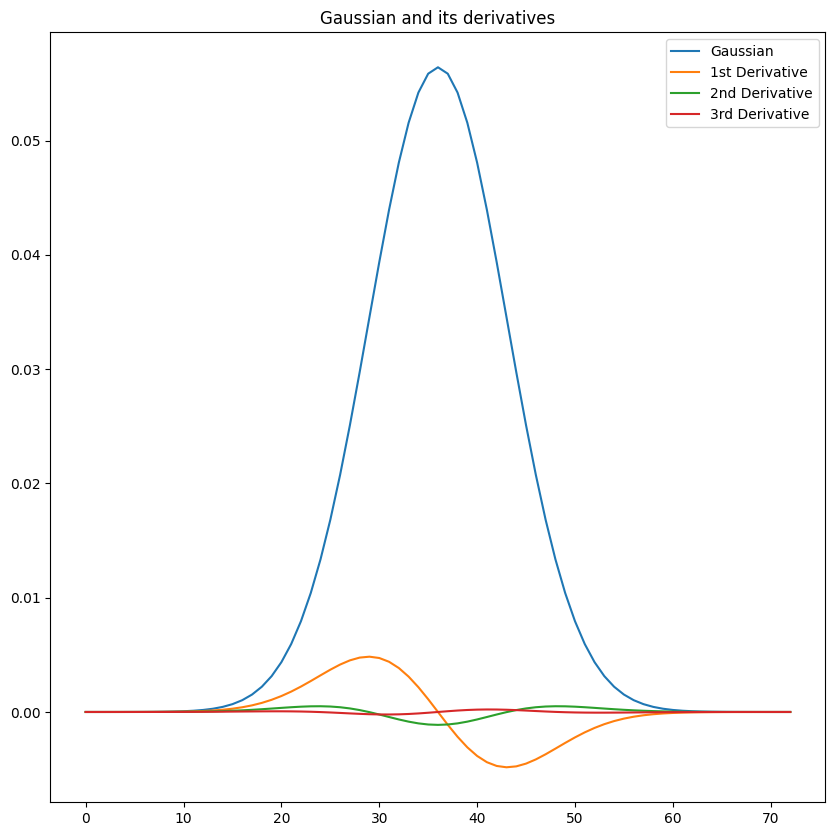

In [34]:
g, dg, ddg, dddg = getGaussDerivative(50)
fig, ax = plt.subplots(1,1,figsize=(10,10),sharex=True,sharey=True)
ax.plot(g)
ax.plot(dg)
ax.plot(ddg)
ax.plot(dddg)
plt.legend(['Gaussian', '1st Derivative', '2nd Derivative', '3rd Derivative'])
plt.title('Gaussian and its derivatives')
plt.show();

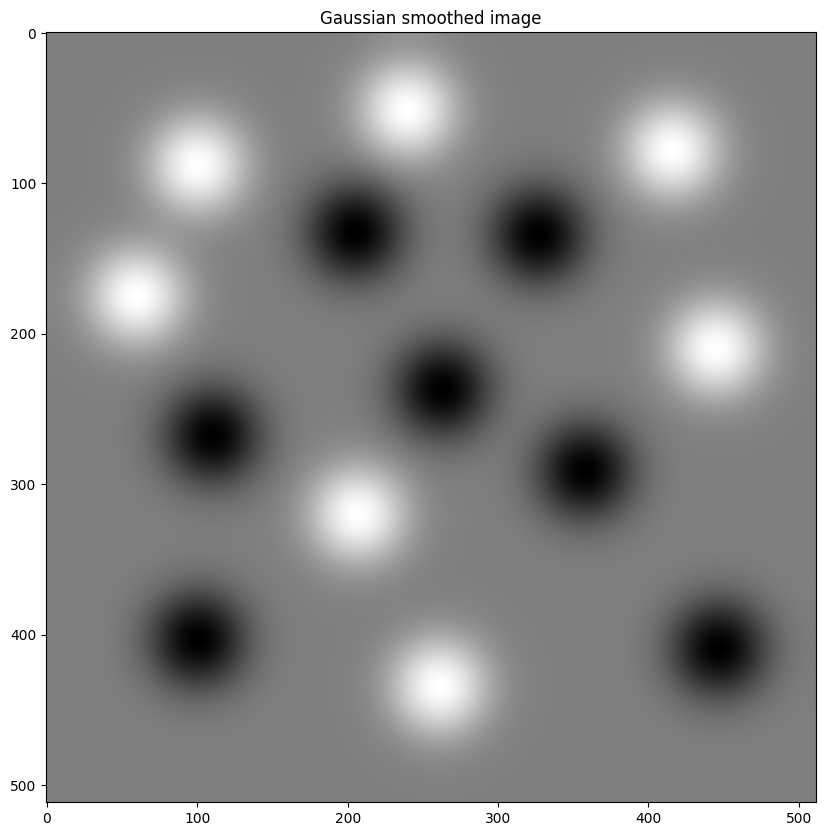

In [35]:
# Convolve the image with a large Gaussian kernel to smooth it
t = 325  # Set the variance (scale) for the Gaussian kernel
g, dg, ddg, dddg = getGaussDerivative(t)  # Get Gaussian and its derivatives for this scale

# Apply Gaussian smoothing in both x and y directions using separable convolution
# First convolve along rows with g, then along columns with g.T
Lg = cv2.filter2D(cv2.filter2D(im, -1, g), -1, g.T)

# Plot the smoothed image
fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True, sharey=True)
ax.imshow(Lg, cmap='gray')
# The result is a heavily smoothed version of the original image, useful for detecting large-scale structures
plt.title('Gaussian smoothed image')
plt.show();

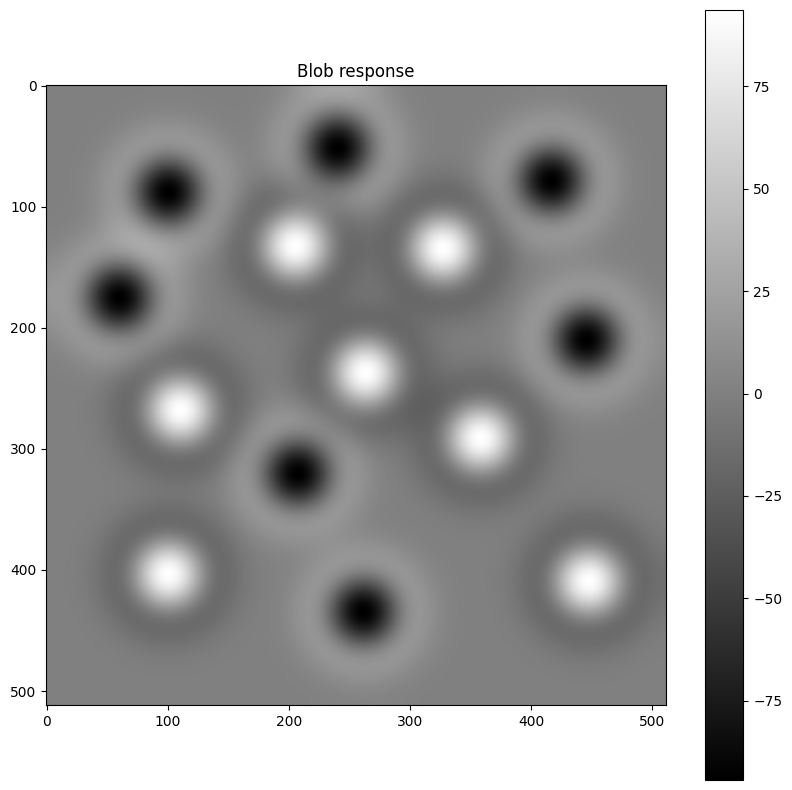

In [40]:
# detecting blobs on one scale 

#%% Detecting blobs on one scale

# Read the test image with uniform blobs and convert to float
im_1_scale = skimage.io.imread(data_path + 'test_blob_uniform.png').astype(float)

# Compute second derivatives of the image using Gaussian kernels
# Lxx: second derivative in x-direction (convolve with g along x, ddg along y)
Lxx = cv2.filter2D(cv2.filter2D(im_1_scale, -1, g), -1, ddg.T)
# Lyy: second derivative in y-direction (convolve with ddg along x, g along y)
Lyy = cv2.filter2D(cv2.filter2D(im_1_scale, -1, ddg), -1, g.T)

# Compute the Laplacian of Gaussian (blob response) at scale t
L_blob = t * (Lxx + Lyy)

# Visualize the blob response image
fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True, sharey=True)
pos = ax.imshow(L_blob, cmap='gray')  # Show the blob response as an image
fig.colorbar(pos)                     # Add a colorbar to indicate response magnitude
plt.title('Blob response')            # Add a title
plt.show();                           # Display the plot


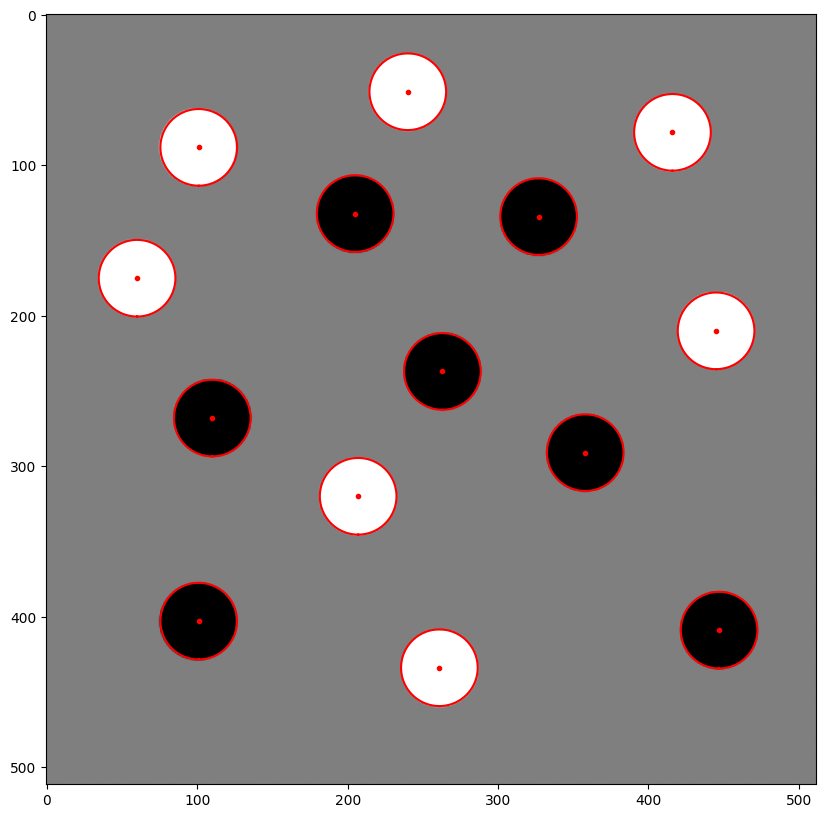

In [41]:
#%% Find regional maximum in Laplacian

# Set the threshold for blob magnitude to filter out weak responses
magnitudeThres = 50

# Find local maxima in the positive Laplacian response (bright blobs)
coord_pos = skimage.feature.peak_local_max(L_blob, threshold_abs=magnitudeThres)

# Find local maxima in the negative Laplacian response (dark blobs)
coord_neg = skimage.feature.peak_local_max(-L_blob, threshold_abs=magnitudeThres)

# Combine coordinates of both bright and dark blobs
coord = np.r_[coord_pos, coord_neg]

# Prepare to draw circles around detected blobs
theta = np.arange(0, 2*np.pi, step=np.pi/100)  # Angles for the circle
theta = np.append(theta, 0)                    # Close the circle
circ = np.array((np.cos(theta), np.sin(theta))) # Unit circle coordinates

n = coord.shape[0]  # Number of detected blobs
m = circ.shape[1]   # Number of points to draw each circle

# Create a new figure for visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True, sharey=True)
ax.imshow(im_1_scale, cmap='gray')  # Show the original image

# Plot the detected blob centers as red dots
plt.plot(coord[:, 1], coord[:, 0], '.r')

# Calculate the circle coordinates for each blob
# The radius is set to sqrt(2*t), which corresponds to the scale used in detection
circ_y = np.sqrt(2*t) * np.reshape(circ[0, :], (1, -1)).T * np.ones((1, n)) + np.ones((m, 1)) * np.reshape(coord[:, 0], (-1, 1)).T
circ_x = np.sqrt(2*t) * np.reshape(circ[1, :], (1, -1)).T * np.ones((1, n)) + np.ones((m, 1)) * np.reshape(coord[:, 1], (-1, 1)).T

# Draw the circles around each detected blob
plt.plot(circ_x, circ_y, 'r')

plt.show()

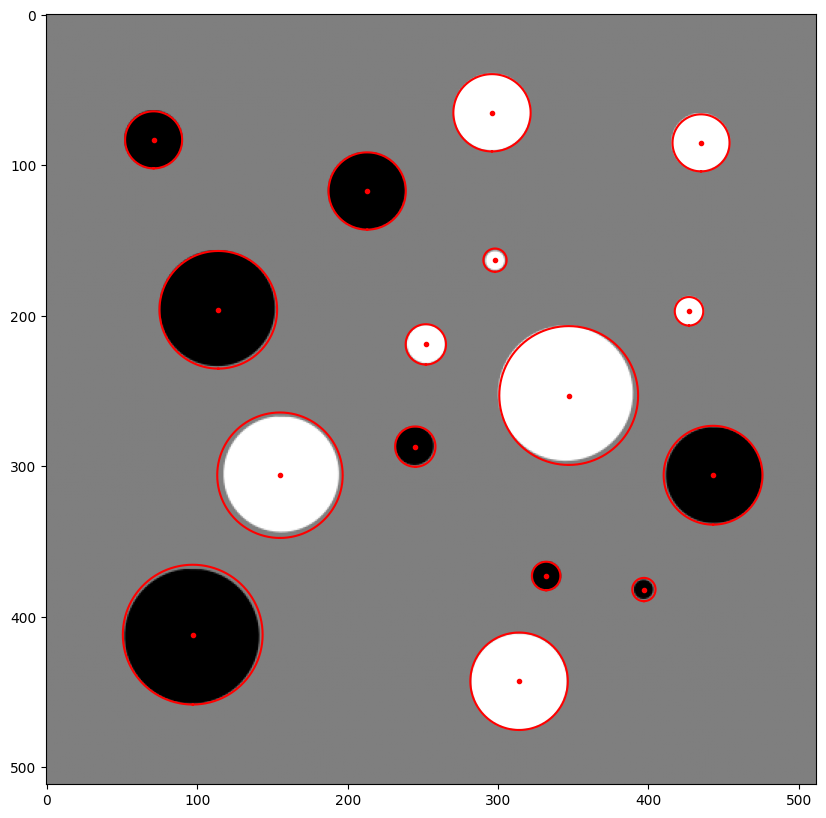

In [42]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Detecting blobs on multiple scales

# Read the image with varying blob sizes and convert to float
im = skimage.io.imread(data_path + 'test_blob_varying.png').astype(float)

t = 15  # Initial variance (scale) for the Gaussian kernel
g, dg, ddg, dddg = getGaussDerivative(t)  # Get Gaussian and its derivatives for this scale

r, c = im.shape  # Get image dimensions
n = 100  # Number of scales to compute in the scale-space
L_blob_vol = np.zeros((r, c, n))  # Allocate space for the scale-space volume
tStep = np.zeros(n)  # Store the scale (variance) at each level

Lg = im  # Start with the original image
for i in range(0, n):
    tStep[i] = t * i  # Compute the current scale (variance)
    # Compute the Laplacian of Gaussian response at this scale
    # Convolve with Gaussian in x and y, then with second derivative in x and y
    L_blob_vol[:, :, i] = t * i * (
        cv2.filter2D(cv2.filter2D(Lg, -1, g), -1, ddg.T) +
        cv2.filter2D(cv2.filter2D(Lg, -1, ddg), -1, g.T)
    )
    # Smooth the image further for the next scale (simulates increasing scale)
    Lg = cv2.filter2D(cv2.filter2D(Lg, -1, g), -1, g.T)

#%% find maxima in scale-space

thres = 40.0  # Threshold for blob response magnitude

# Find local maxima in the positive Laplacian response (bright blobs)
coord_pos = skimage.feature.peak_local_max(L_blob_vol, threshold_abs=thres)
# Find local maxima in the negative Laplacian response (dark blobs)
coord_neg = skimage.feature.peak_local_max(-L_blob_vol, threshold_abs=thres)
# Combine coordinates of both bright and dark blobs
coord = np.r_[coord_pos, coord_neg]

# Prepare to draw circles around detected blobs
theta = np.arange(0, 2 * np.pi, step=np.pi / 100)  # Angles for the circle
theta = np.append(theta, 0)  # Close the circle
circ = np.array((np.cos(theta), np.sin(theta)))  # Unit circle coordinates

n = coord.shape[0]  # Number of detected blobs
m = circ.shape[1]   # Number of points to draw each circle

# Visualize the detected blobs
fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True, sharey=True)
ax.imshow(im, cmap='gray')  # Show the original image

# Plot the detected blob centers as red dots
plt.plot(coord[:, 1], coord[:, 0], '.r')

# Calculate the scale (variance) for each detected blob
scale = tStep[coord[:, 2]]

# Calculate the circle coordinates for each blob
# The radius is set to sqrt(2*scale), which corresponds to the scale used in detection
circ_y = np.sqrt(2 * scale) * np.reshape(circ[0, :], (1, -1)).T * np.ones((1, n)) + np.ones((m, 1)) * np.reshape(coord[:, 0], (-1, 1)).T
circ_x = np.sqrt(2 * scale) * np.reshape(circ[1, :], (1, -1)).T * np.ones((1, n)) + np.ones((m, 1)) * np.reshape(coord[:, 1], (-1, 1)).T

# Draw the circles around each detected blob
plt.plot(circ_x, circ_y, 'r')

plt.show();


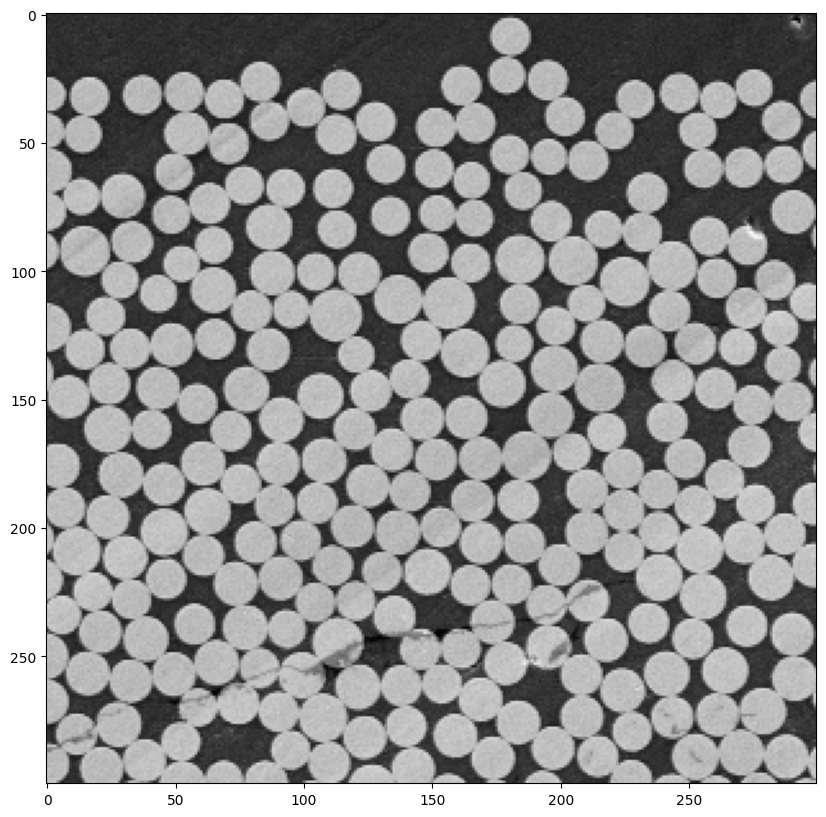

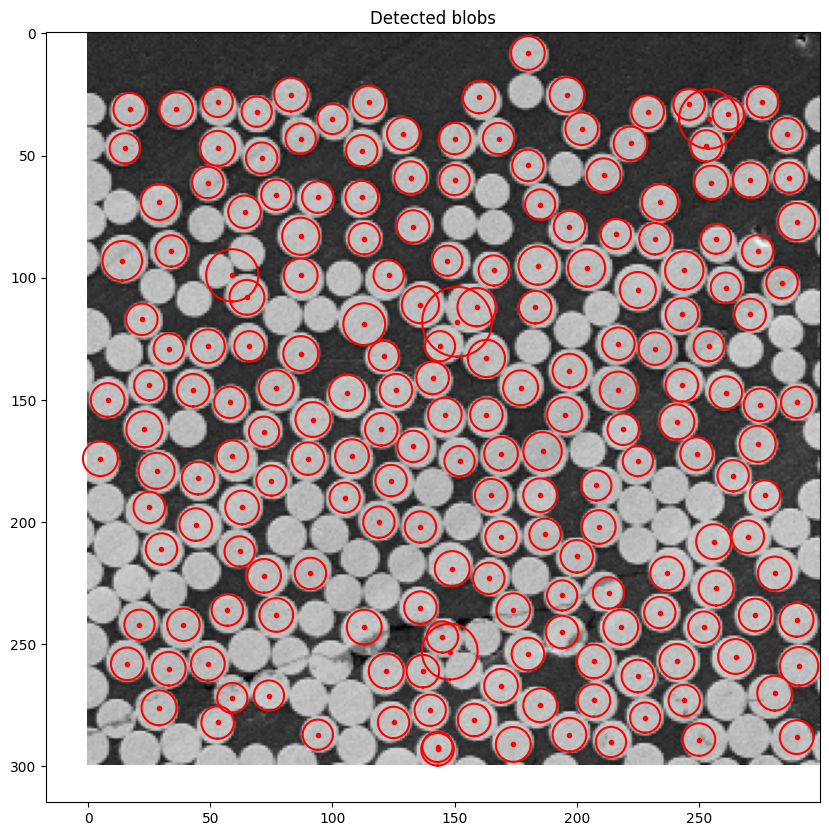

In [43]:
# Detecting blobs in real data (scale space)

# Define the interval of diameters (in pixels) and the step size for the blobs to be detected
d = np.arange(10, 24.5, step=0.4)  # Diameters from 10 to 24 (inclusive) with step 0.4
# Convert diameters to scale (variance) for the Gaussian kernel using the formula t = sqrt(0.5) * (radius^2)
tStep = np.sqrt(0.5) * ((d / 2) ** 2)  # tStep contains the scale for each diameter

# Read the SEM image and extract a region of interest (ROI) for analysis
im = skimage.io.imread(data_path + 'SEM.png').astype(float)  # Read image as float for processing
im = im[200:500, 200:500]  # Crop to a 300x300 region for faster computation and focus

# Display the cropped image
fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True, sharey=True)
ax.imshow(im, cmap='gray')  # Show the image in grayscale

#%% Compute scale space

r, c = im.shape        # Get the number of rows and columns in the cropped image
n = d.shape[0]         # Number of scales (diameters) to process
L_blob_vol = np.zeros((r, c, n))  # Allocate a 3D array to store the blob response at each scale

# Loop over each scale (corresponding to a diameter)
for i in range(0, n):
    # Compute the 1D Gaussian and its derivatives for the current scale
    g, dg, ddg, dddg = getGaussDerivative(tStep[i])
    # Compute the Laplacian of Gaussian (LoG) response at this scale:
    # - Convolve the image with the Gaussian in x and y, then with the second derivative in x and y
    # - The sum of second derivatives in x and y gives the Laplacian
    # - Multiply by the scale (tStep[i]) for scale normalization
    L_blob_vol[:, :, i] = tStep[i] * (
        cv2.filter2D(cv2.filter2D(im, -1, g), -1, ddg.T) +
        cv2.filter2D(cv2.filter2D(im, -1, ddg), -1, g.T)
    )

#%% Find maxima in scale space

thres = 30  # Threshold for blob response magnitude; only strong blobs are considered

# Find local maxima in the negative Laplacian response (detecting dark blobs)
# Returns coordinates as (row, col, scale_index)
coord = skimage.feature.peak_local_max(-L_blob_vol, threshold_abs=thres)

# Show circles

def getCircles(coord, scale):
    '''
    Compute the (x, y) coordinates for drawing circles around detected blobs.

    Parameters
    ----------
    coord : numpy array
        2D array of coordinates (n_blobs x 2), where each row is (row, col).
    scale : numpy array
        1D array of scale (variance t) for each blob.

    Returns
    -------
    circ_x : numpy array
        x coordinates of circle. Each column is one circle.
    circ_y : numpy array
        y coordinates of circle. Each column is one circle.

    '''
    # Generate points on a unit circle (for drawing)
    theta = np.arange(0, 2 * np.pi, step=np.pi / 100)  # 200 points around the circle
    theta = np.append(theta, 0)  # Close the circle
    circ = np.array((np.cos(theta), np.sin(theta)))  # Shape: (2, num_points)
    n = coord.shape[0]  # Number of blobs
    m = circ.shape[1]   # Number of points per circle

    # Compute y and x coordinates for each circle:
    # - The radius is sqrt(2*scale) (corresponds to the scale of the blob)
    # - Each circle is centered at the blob coordinate
    circ_y = np.sqrt(2 * scale) * circ[[0], :].T * np.ones((1, n)) + np.ones((m, 1)) * coord[:, [0]].T
    circ_x = np.sqrt(2 * scale) * circ[[1], :].T * np.ones((1, n)) + np.ones((m, 1)) * coord[:, [1]].T
    return circ_x, circ_y

# Extract the scale (variance) for each detected blob using the third column of coord
scale = tStep[coord[:, 2]]

# Compute the circle coordinates for visualization
circ_x, circ_y = getCircles(coord[:, 0:2], scale)

# Plot the detected blobs and their corresponding circles on the image
fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True, sharey=True)
ax.imshow(im, cmap='gray')  # Show the image
plt.plot(coord[:, 1], coord[:, 0], '.r')  # Plot blob centers as red dots
plt.plot(circ_x, circ_y, 'r')             # Draw red circles around each blob
plt.title('Detected blobs')               # Add a title
plt.show();  # Display the plot


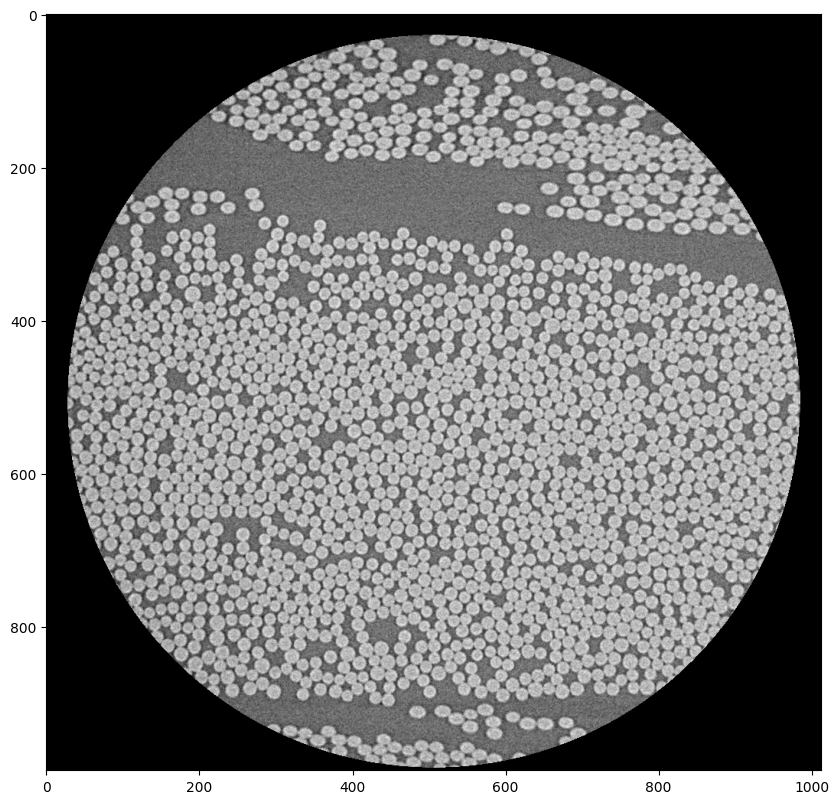

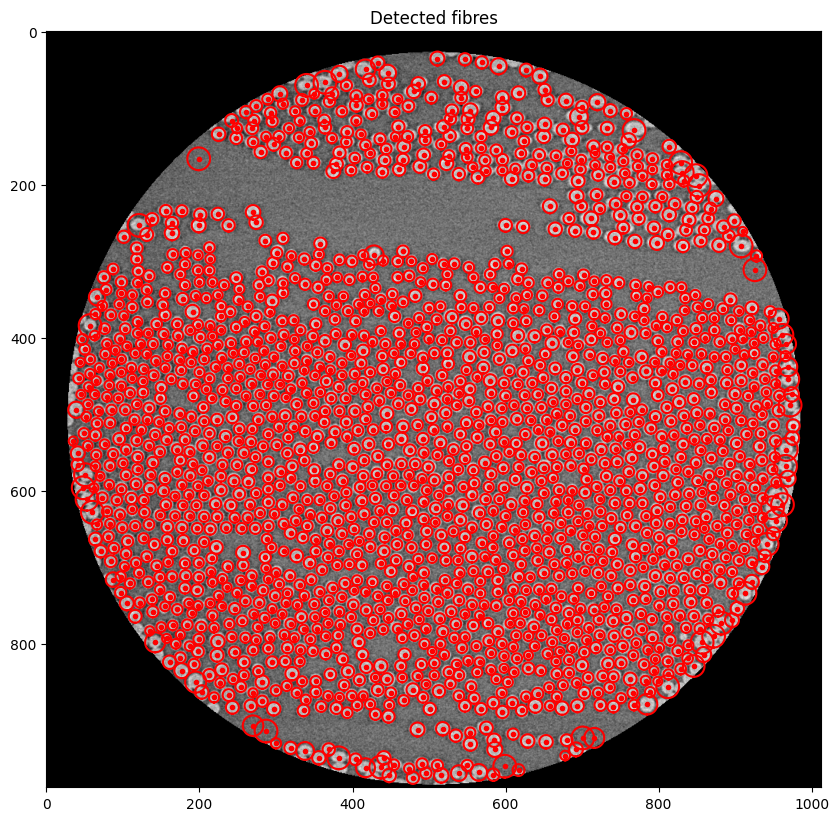

In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Localize blobs - Example high resolution lab X-ray CT - find the coordinates 
# using Gaussian smoothing and use the scale space to find the scale 

im = skimage.io.imread(data_path + 'CT_lab_high_res.png').astype(float)/255

fig, ax = plt.subplots(1,1,figsize=(10,10),sharex=True,sharey=True)
ax.imshow(im, cmap='gray')

# %% Set parameters
def detectFibers(im, diameterLimit, stepSize, tCenter, thresMagnitude):
    '''
    Detects fibers in images by finding maxima of Gaussian smoothed image

    Parameters
    ----------
    im : numpy array
        Image.
    diameterLimit : numpy array
        2 x 1 vector of limits of diameters of the fibers (in pixels).
    stepSize : float
        step size in pixels.
    tCenter : float
        Scale of the Gaussian for center detection.
    thresMagnitude : float
        Threshold on blob magnitude.

    Returns
    -------
    coord : numpy array
        n x 2 array of coordinates with row and column coordinates in each column.
    scale : numpy array
        n x 1 array of scales t (variance of the Gaussian).

    '''
    
    radiusLimit = diameterLimit/2
    radiusSteps = np.arange(radiusLimit[0], radiusLimit[1]+0.1, stepSize)
    tStep = radiusSteps**2/np.sqrt(2)
    
    r,c = im.shape
    n = tStep.shape[0]
    L_blob_vol = np.zeros((r,c,n))
    for i in range(0,n):
        g, dg, ddg, dddg = getGaussDerivative(tStep[i])
        L_blob_vol[:,:,i] = tStep[i]*(cv2.filter2D(cv2.filter2D(im,-1,g),-1,ddg.T) + 
                                      cv2.filter2D(cv2.filter2D(im,-1,ddg),-1,g.T))
    # Detect fibre centers
    g, dg, ddg, dddg = getGaussDerivative(tCenter)
    Lg = cv2.filter2D(cv2.filter2D(im, -1, g), -1, g.T)
    
    coord = skimage.feature.peak_local_max(Lg, threshold_abs = thresMagnitude)
    
    # Find coordinates and size (scale) of fibres
    magnitudeIm = np.min(L_blob_vol, axis = 2)
    scaleIm = np.argmin(L_blob_vol, axis = 2)
    scales = scaleIm[coord[:,0], coord[:,1]]
    magnitudes = -magnitudeIm[coord[:,0], coord[:,1]]
    idx = np.where(magnitudes > thresMagnitude)
    coord = coord[idx[0],:]
    scale = tStep[scales[idx[0]]]
    return coord, scale


#%% Set parameters

# Radius limit
diameterLimit = np.array([10,25])
stepSize = 0.3

# Parameter for Gaussian to detect center point
tCenter = 20

# Parameter for finding maxima over Laplacian in scale-space
thresMagnitude = 8

# Detect fibres
coord, scale = detectFibers(im, diameterLimit, stepSize, tCenter, thresMagnitude)

# Plot detected fibres
fig, ax = plt.subplots(1,1,figsize=(10,10),sharex=True,sharey=True)
ax.imshow(im, cmap='gray')
ax.plot(coord[:,1], coord[:,0], 'r.')
circ_x, circ_y = getCircles(coord, scale)
plt.plot(circ_x, circ_y, 'r')
plt.title('Detected fibres')
plt.show();